In [46]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [2]:
# Setting Constants

#position boundaries
x_0 = 0
x_endpoints = np.linspace(0,2,101)

#time boundaries
t_i = 0
t_f = 6

#other constants
mass = 1
steps = 7
numb_paths = 1000

#array of times
times = np.linspace(t_i, t_f, steps)
dt = times[1] - times [0]
print(x_endpoints)

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06 1.08 1.1
 1.12 1.14 1.16 1.18 1.2  1.22 1.24 1.26 1.28 1.3  1.32 1.34 1.36 1.38
 1.4  1.42 1.44 1.46 1.48 1.5  1.52 1.54 1.56 1.58 1.6  1.62 1.64 1.66
 1.68 1.7  1.72 1.74 1.76 1.78 1.8  1.82 1.84 1.86 1.88 1.9  1.92 1.94
 1.96 1.98 2.  ]


# Basic Path function and action integral

In [3]:
#Creating the position generating function

def Pos_Gen(x0, xN, Steps, noise_scale =0.3): #Generates smooth paths with noise
    xs = np.linspace(x0, xN, Steps)
    noise = np.random.normal(0, noise_scale, size=Steps)
    noise[0] = 0.0
    noise[-1] = 0.0
    return xs + noise

In [4]:
#Creating function to evaluate the action integral for a path

def action_harmonic(positions, times, mass):

    #Input Validation
    if type(positions) != np.ndarray:
        raise TypeError("WARNING: position input is not a numpy array")
    if type(times) != np.ndarray:
        raise TypeError("WARNING: time input is not a numpy array")

    #Calculating the action using discrete steps and straight line approx
    S = 0
    for i in range(len(times)-1):
        dt = times[i+1] - times[i]
        dx = positions[i+1] - positions[i]
        T = 0.5 * mass * (dx/dt)**2
        V = 0.5 * (((positions[i]+positions[i+1])/2)**2)
        S +=dt*(T + V)

    return S

# Generating Paths and calculating weight of each path

In [5]:
paths = []
weights = []
x_end = []

for xN in x_endpoints:
    for _ in range(numb_paths):
        p = Pos_Gen(x_0, xN, steps)
        S = action_harmonic(p, times, mass)
        w = np.exp(-S)
        paths.append(p)
        weights.append(w)
        x_end.append(xN)

paths = np.array(paths)
weights = np.array(weights)
x_end = np.array(x_end)

In [6]:
print(len(paths))
print(paths[1001])

101000
[ 0.          0.32425935 -0.04026399 -0.50824828 -0.16802788 -0.29315427
  0.02      ]


# Finding the groundstate wave function of the path

In [7]:
x_bins = np.linspace(0,2,101)

pdf_unnormalised, bin_edges = np.histogram(x_end, bins = x_bins, weights = weights)
x_centres = 0.5*(bin_edges[1:] + bin_edges[:-1])
dx = np.diff(x_bins)[0]

# normalize to integrate to 0.5 (since we only use x > 0)
area = np.sum(pdf_unnormalised * dx)
pdf = pdf_unnormalised / (2 * area)

# --- Analytic PDF for comparison (half side only) ---
phi_sq_analytic = (1/np.sqrt(np.pi)) * np.exp(-x_centres**2)
phi_sq_analytic /= 2 * np.sum(phi_sq_analytic * dx)  # normalize area to 0.5

# --- Check areas ---
print(f"Numerical PDF area: {np.sum(pdf*dx):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic*dx):.5f}")

Numerical PDF area: 0.50000
Analytic PDF area: 0.50000


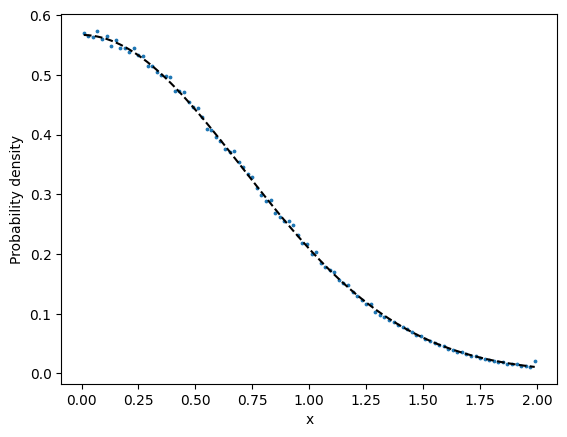

In [8]:
save_path = r"C:\Users\Sebastian\Documents\University work\Year 3\Computational Physics\Wavefunction.svg"

plt.figure(1)
plt.scatter(x_centres, pdf, label='Path integral estimate',s = 3)
plt.plot(x_centres, phi_sq_analytic, 'k--', label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.savefig(save_path, bbox_inches='tight', format = 'svg')
plt.show()

In [9]:
i_099 = np.searchsorted(x_centres, 0.99)
i_101 = np.searchsorted(x_centres, 1.01)

# Fitting Model

In [47]:
#define model

def oscillator_model(x,A,B):
    return A*np.exp(-B*x**2)

p0_osc = [1/np.sqrt(np.pi), 1]

In [52]:
popt_osc, cov_osc = opt.curve_fit(oscillator_model,
                                  x_centres,
                                  pdf,
                                  p0=p0_osc)

osc_err = np.sqrt(np.diag(cov_osc))

In [54]:
y_max = oscillator_model(x_centres,popt_osc[0]+osc_err[0],popt_osc[1]+osc_err[1])
y_min = oscillator_model(x_centres,popt_osc[0]-osc_err[0],popt_osc[1]-osc_err[1])

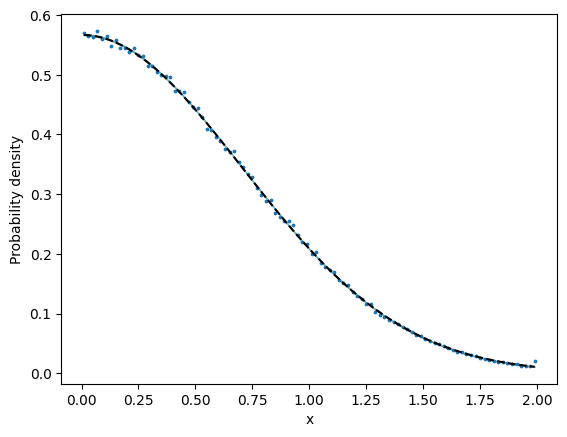

In [57]:
plt.figure(1)
plt.fill_between(x_centres, y_max, y_min, color = 'teal', alpha = 0.5)

plt.scatter(x_centres, pdf, label='Path integral estimate',s = 3)
plt.plot(x_centres, phi_sq_analytic, 'k--', label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x')
plt.ylabel('Probability density')

plt.show()

# Bootstrapping for errorbars

In [59]:
n_boot = 1000
boot_A = []
boot_B = []


y_pred = oscillator_model(x_centres, *popt_osc)

# Compute residuals
residuals = pdf - y_pred

for i in range(n_boot):
    # Resample residuals with replacement
    resampled_residuals = np.random.choice(residuals, size=len(residuals), replace=True)

    # Create new bootstrap sample
    pdf_boot = y_pred + resampled_residuals

    try:
        # Refit to the bootstrap sample
        popt_b, _ = opt.curve_fit(oscillator_model, x_centres, pdf_boot, p0=popt_osc)
        boot_A.append(popt_b[0])
        boot_B.append(popt_b[1])
    except RuntimeError:
        # If fitting fails, skip this iteration
        continue

# Convert to arrays
boot_A = np.array(boot_A)
boot_B = np.array(boot_B)

# Parameter uncertainties
A_mean, B_mean = np.mean(boot_A), np.mean(boot_B)
A_std, B_std = np.std(boot_A), np.std(boot_B)

print(f"A = {A_mean:.4f} ± {A_std:.4f}")
print(f"B = {B_mean:.4f} ± {B_std:.4f}")

# Optional: compute 1σ confidence band for y
y_boot_all = np.array([oscillator_model(x_centres, a, b) for a, b in zip(boot_A, boot_B)])
y_mean = np.mean(y_boot_all, axis=0)
y_std = np.std(y_boot_all, axis=0)

print(y_std)

A = 0.5674 ± 0.0009
B = 1.0018 ± 0.0037
[0.0009264  0.00092467 0.00092123 0.00091611 0.00090932 0.00090094
 0.00089101 0.00087961 0.00086683 0.00085277 0.00083752 0.00082122
 0.000804   0.00078599 0.00076736 0.00074827 0.00072889 0.00070942
 0.00069005 0.00067097 0.0006524  0.00063453 0.00061759 0.00060176
 0.00058724 0.0005742  0.00056278 0.00055311 0.00054526 0.00053928
 0.00053516 0.00053285 0.00053227 0.00053328 0.00053574 0.00053945
 0.00054423 0.00054987 0.00055617 0.00056293 0.00056995 0.00057707
 0.00058411 0.00059093 0.0005974  0.00060339 0.00060881 0.00061358
 0.00061761 0.00062085 0.00062326 0.00062479 0.00062543 0.00062516
 0.00062397 0.00062186 0.00061884 0.00061494 0.00061015 0.00060453
 0.00059808 0.00059086 0.00058289 0.00057422 0.00056488 0.00055493
 0.00054441 0.00053336 0.00052184 0.00050989 0.00049756 0.0004849
 0.00047196 0.00045877 0.0004454  0.00043187 0.00041824 0.00040455
 0.00039083 0.00037712 0.00036346 0.00034988 0.00033642 0.0003231
 0.00030995 0.00029699 0

# Checking for Outliers

In [10]:
from sklearn.ensemble import IsolationForest

In [64]:
#calculating residuals

def residual_calculator(y_obs,y_theoretical,errorbar):
    r = (y_obs - y_theoretical)/errorbar
    f = r/np.std(r)
    return  f

residuals = residual_calculator(pdf, phi_sq_analytic, y_std)
print(len(residuals))

print(residuals)

100
[ 0.34317475 -0.18510907 -0.22922448  1.12921192 -0.32537361  0.58077029
 -1.13836957  0.41326422 -0.64527087 -0.28123088 -0.54216431  1.02285752
  0.16301817  0.57066818 -0.88169839 -0.04742451 -0.66447799 -0.33911274
  0.57490658  1.47929759 -0.93067917  0.27016868  1.59081746  0.05028606
  0.10991114  1.39875707  0.2133592  -1.8211474  -0.39685413 -0.96614619
 -0.34886717 -1.24030738 -0.18489279  2.29869226  0.32086985  0.74311297
  0.36888923  1.25039853 -0.48490831 -0.87919917 -1.08734637  0.96345436
 -1.24881135 -0.87334772 -0.23574178  1.24242638  1.75579094  0.19148895
 -0.37505657  0.74574324 -0.8402256   1.09553103 -0.54491463 -0.47164771
  0.1467548   0.79324623 -0.44232858  0.01981774  0.58967198 -0.31761392
 -0.42662819 -0.22346741 -0.48662902  0.46377695 -1.00450937 -0.82697552
 -0.51423369 -0.48019648 -0.3119848  -0.0567216  -0.0722311   0.18843805
  0.1586704  -0.12071938  0.06813081 -0.2150527  -0.07557518  0.03942082
  0.0422358  -0.04365635 -0.24157588 -0.1895144

In [70]:
model = IsolationForest(contamination = 0.05, random_state = 42)
X = np.column_stack([x_centres, residuals])
labels = model.fit_predict(X) #1 = inlier, -1 = outlier

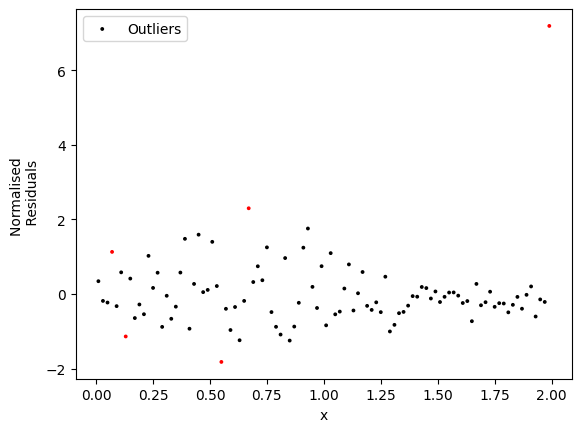

In [71]:
plt.figure(1)
# plt.axhline(0, color = "black", linestyle = '--')
# plt.axhline(1, color = "grey", linestyle = '--', alpha = 0.4)
# plt.axhline(-1, color = "grey", linestyle = '--', alpha = 0.4)
outliers = labels ==-1

plt.scatter(x_centres, residuals, c = np.where(outliers,'r','k'), s = 3, label = 'Data')
plt.legend(['Outliers', 'Inliers'])

plt.xlabel('x')
plt.ylabel('Normalised \n Residuals')

plt.show()

# Plot for the poster

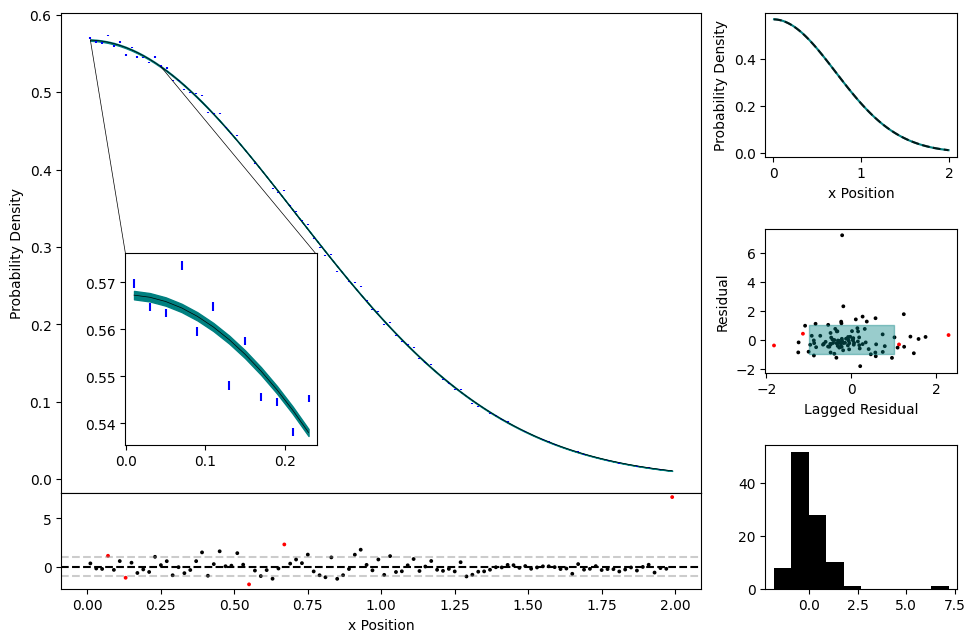

In [174]:
save_path = r"C:\Users\Sebastian\Documents\University work\Year 3\Computational Physics\Poster_Plot.svg"


fig = plt.figure(1)

#main plot
fig.add_axes([0,0,1,1])

plt.errorbar(x_centres, pdf,yerr = y_std, color = "blue", linestyle ='none')
plt.plot(x_centres,oscillator_model(x_centres,popt_osc[0],popt_osc[1]), color = 'black', linewidth = 0.5)
plt.fill_between(x_centres,y_min, y_max, color = 'teal')

plt.xticks([])

plt.ylabel("Probability Density")

#inset blowup of linesection

start_index = 0
end_index = 12
plt.plot([x_centres[start_index],0.13],[oscillator_model(x_centres[start_index],*popt_osc), 0.29], color = 'black', linewidth = 0.5)
plt.plot([x_centres[end_index],0.78],[oscillator_model(x_centres[end_index],*popt_osc), 0.29], color = 'black', linewidth = 0.5)

inset = fig.add_axes([0.1, 0.1, 0.3, 0.4])

inset.errorbar(x_centres[start_index:end_index], pdf[start_index:end_index],yerr = y_std[start_index:end_index], color = "blue", linestyle ='none')
inset.plot(x_centres[start_index:end_index],oscillator_model(x_centres[start_index:end_index],popt_osc[0],popt_osc[1]), color = 'black', linewidth = 0.5)
inset.fill_between(x_centres[start_index:end_index],y_min[start_index:end_index], y_max[start_index:end_index], color = 'teal')

#residual plot
fig.add_axes([0,-0.2,1,0.2])
plt.xlabel("x Position")

plt.axhline(0, color = 'black', linestyle = '--')
plt.axhline(1, color = 'grey', linestyle = '--',alpha = 0.4)
plt.axhline(-1, color = 'grey', linestyle = '--',alpha = 0.4)

plt.scatter(x_centres, residuals, c = np.where(outliers,'r','k'), s = 3)

#Fit with analytic Plot
fp = fig.add_axes([1.1, 0.7, 0.3, 0.3])
#fp.set_title('Fit Comparison')
fp.set_xlabel('x Position')
fp.set_ylabel('Probability Density')
fp.plot(x_centres, oscillator_model(x_centres,*popt_osc), color = 'teal')
fp.plot(x_centres, phi_sq_analytic,color = 'black', linestyle = '--', alpha =0.8)

#Lagplot
lp = fig.add_axes([1.1, 0.25, 0.3, 0.3])
#lp.set_title('Residual Lagplot')
lp.set_xlabel('Lagged Residual')
lp.set_ylabel('Residual')

R_1 = residuals[0:len(residuals)-1]
R_i = residuals[1:]

lp.scatter(R_1,R_i, s = 3, c = np.where(outliers[0:len(outliers)-1],'r','k'))
lp.fill_between([-1,1],1,-1, color = 'teal', alpha = 0.4)

#Residual histogram plot
hp = fig.add_axes([1.1, -0.2, 0.3, 0.3])
#hp.set_title('Residual Distribution')
hp.hist(residuals, bins = 10, color = 'black')


plt.savefig(save_path, bbox_inches='tight', format = 'svg')
plt.show()